# Human Activity Recognition from Wearable Inertial Sensor Networks Part 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Table of Contents
- [Import library and define visualization parameters](#Import-library-and-define-visualization-parameters)
- [Import data](#Import-data)
- [Target output engineering](#Target-output-engineering)
- [Prepare data for Machine Learning](#Prepare-data-for-Machine-Learning)
- [Save data in pickle format in google drive](#Save-data-in-pickle-format-in-google-drive)


# Import library and define visualization parameters

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import pickle
import os
from sklearn.manifold import TSNE
from subprocess import call
from pylab import rcParams

import warnings 
warnings.filterwarnings('ignore')

# Display several outputs on a notebook output
from IPython.display import Image  
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Define certain standard parameters at the outset
pd.options.display.float_format = '{: .4f}'. format
np.set_printoptions(precision=4)
plt.style.use ('ggplot')
# Files
path_to_file = '/content/drive/MyDrive/myproject/outputdata'

# Import data

In [ ]:
!cp /content/drive/MyDrive/myproject/outputdata/df_3.pkl /tmp/df_3.pkl

In [ ]:
df = pd.read_pickle('/tmp/df_3.pkl')
df

,act,filename,acc_rf_x_amin,acc_rf_x_amax,acc_rf_x_mean,acc_rf_x_median,acc_rf_x_std,acc_rf_x_skew,acc_rf_x_kurtosis,acc_rf_x_iqr,acc_rf_x_median_absolute_deviation,acc_rf_x_mad,acc_rf_x_ran,acc_rf_y_amin,acc_rf_y_amax,acc_rf_y_mean,acc_rf_y_median,acc_rf_y_std,acc_rf_y_skew,acc_rf_y_kurtosis,acc_rf_y_iqr,acc_rf_y_median_absolute_deviation,acc_rf_y_mad,acc_rf_y_ran,acc_rf_z_amin,acc_rf_z_amax,acc_rf_z_mean,acc_rf_z_median,acc_rf_z_std,acc_rf_z_skew,acc_rf_z_kurtosis,acc_rf_z_iqr,acc_rf_z_median_absolute_deviation,acc_rf_z_mad,acc_rf_z_ran,gyro_rf_x_amin,gyro_rf_x_amax,gyro_rf_x_mean,gyro_rf_x_median,gyro_rf_x_std,...,long_acc_iqr,long_acc_median_absolute_deviation,long_acc_mad,long_acc_ran,gyro_norm_amin,gyro_norm_amax,gyro_norm_mean,gyro_norm_median,gyro_norm_std,gyro_norm_skew,gyro_norm_kurtosis,gyro_norm_iqr,gyro_norm_median_absolute_deviation,gyro_norm_mad,gyro_norm_ran,colat_gyro_amin,colat_gyro_amax,colat_gyro_mean,colat_gyro_median,colat_gyro_std,colat_gyro_skew,colat_gyro_kurtosis,colat_gyro_iqr,colat_gyro_median_absolute_deviation,colat_gyro_mad,colat_gyro_ran,long_gyro_amin,long_gyro_amax,long_gyro_mean,long_gyro_median,long_gyro_std,long_gyro_skew,long_gyro_kurtosis,long_gyro_iqr,long_gyro_median_absolute_deviation,long_gyro_mad,long_gyro_ran,index,activity,person
0,9,/content/drive/MyDrive/myproject/data/HuGaDB_v...,-26828.0000,228.0000,-14573.2955,-15614.0000,5793.7028,0.1629,-0.8552,9196.0000,6473.0316,4944.5560,27056.0000,-5964.0000,8844.0000,1925.3182,1846.0000,2520.9770,-0.1507,0.2721,3458.0000,2748.7404,1996.3631,14808.0000,-716.0000,17512.0000,6885.6818,6854.0000,3032.2412,0.4930,0.7177,3854.0000,2873.2788,2349.0573,18228.0000,-7436.0000,7932.0000,-573.8693,-512.5000,4063.0418,...,0.4017,0.1865,2.0664,6.2716,945.3571,23264.5105,10310.5263,10026.8826,5410.1511,0.2343,-0.7897,8611.3435,6434.9378,4575.3236,22319.1535,0.7905,2.4534,1.5761,1.7191,0.3832,0.0089,-1.2411,0.6793,0.5010,0.3500,1.6628,-2.7910,3.0252,-0.1613,0.9271,1.7209,-0.1405,-1.7772,3.2849,1.2820,1.6712,5.8162,0,Bicycling,01
1,9,/content/drive/MyDrive/myproject/data/HuGaDB_v...,-32768.0000,2744.0000,-15908.3182,-17936.0000,8476.0718,0.2310,-1.0835,13653.0000,10247.7312,7440.2546,35512.0000,-7160.0000,11156.0000,1906.0909,2280.0000,3006.8416,-0.2840,0.3281,3892.0000,2653.8540,2344.5134,18316.0000,-2660.0000,16468.0000,6917.0682,7444.0000,4221.9786,-0.3141,-0.6804,5915.0000,4581.2340,3497.1772,19128.0000,-8612.0000,6710.0000,-724.3693,-1421.5000,4409.9493,...,2.5134,0.2027,2.1566,6.2694,1842.2904,26660.7860,13272.7228,13334.5933,6810.6574,0.0467,-1.1338,11651.8404,8842.4359,5783.4449,24818.4956,0.5558,2.3396,1.5991,1.8195,0.4306,-0.1726,-1.4494,0.7665,0.5667,0.4046,1.7838,-2.7197,2.5692,-0.4510,-1.7267,1.6603,0.1622,-1.8353,3.2286,1.0716,1.6168,5.2889,1,Bicycling,01
2,9,/content/drive/MyDrive/myproject/data/HuGaDB_v...,-30940.0000,1836.0000,-16694.3182,-18150.0000,8272.1209,0.4232,-0.8617,13774.0000,9230.6676,7004.7557,32776.0000,-6472.0000,8020.0000,1933.4773,2478.0000,2786.0552,-0.3112,-0.3191,3741.0000,2745.7752,2283.8549,14492.0000,-3380.0000,14924.0000,6404.4545,7276.0000,3980.7550,-0.4040,-0.7550,6252.0000,4237.2708,3361.0393,18304.0000,-8296.0000,6519.0000,333.5682,678.5000,3950.7688,...,2.2976,0.1884,2.1428,6.2821,1013.4639,25378.0033,12059.3191,12647.7960,6183.3921,0.0505,-0.9531,9699.8500,7468.2433,5196.0901,24364.5394,0.7882,2.5435,1.5631,1.4746,0.4225,0.2112,-1.2869,0.7831,0.5797,0.3847,1.7553,-2.9461,2.7416,-0.0474,1.0783,1.6228,-0.2627,-1.7239,3.2073,0.7663,1.5615,5.6877,2,Bicycling,01
3,9,/content/drive/MyDrive/myproject/data/HuGaDB_v...,-27988.0000,100.0000,-14594.7045,-15108.0000,7188.4512,0.0694,-1.1602,12289.0000,9310.7280,6313.0522,28088.0000,-4552.0000,9284.0000,1653.3409,1506.0000,2464.6819,0.0466,-0.1943,3227.0000,2378.0904,1963.5834,13836.0000,-1880.0000,11880.0000,5811.5455,6510.0000,3210.8786,-0.3152,-0.9499,5090.0000,3641.2656,2741.2789,13760.0000,-8277.0000,6905.0000,-656.3295,-1238.5000,3933.6015,...,0.7448,0.2751,2.1651,

# Target output engineering

In [ ]:
set(df.activity.to_list())

{'Bicycling',
 'Down by elevator',
 'Going down',
 'Going up',
 'Running',
 'Sitting',
 'Sitting down',
 'Sitting in car',
 'Standing',
 'Standing up',
 'Up by elevator',
 'Walking'}

In [ ]:
new_activity_dictionary = {'Down by elevator' : 'Standing', 'Standing up' : 'Standing', 'Up by elevator' : 'Standing', 'Going down' : 'Walking', 'Going up' : 'Walking', 'Sitting down' : 'Sitting', 'Sitting in car' : 'Sitting'} 
df['activity'] = df['activity'].replace(new_activity_dictionary)

In [ ]:
set(df.activity.to_list())

{'Bicycling', 'Running', 'Sitting', 'Standing', 'Walking'}

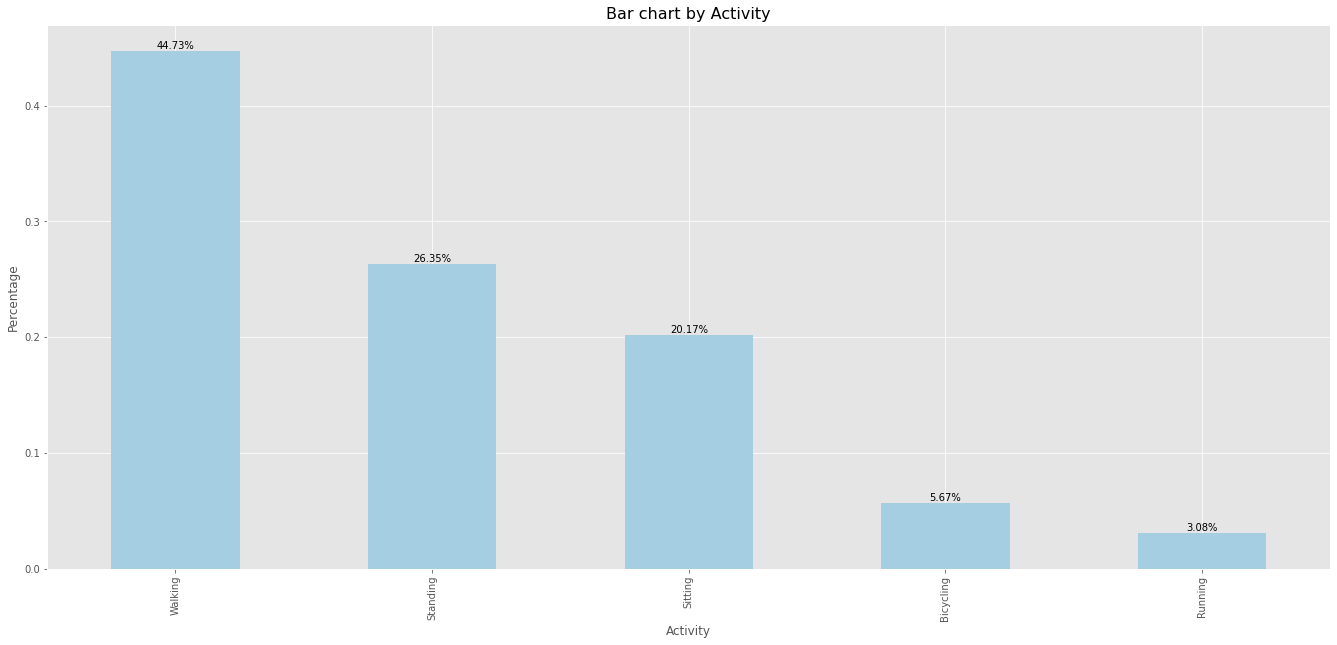

In [ ]:
result = df['activity'].value_counts()
ax = (result.div(result.sum(), axis=0)).plot(kind='bar', figsize=(23,10), stacked=True, colormap='Paired')
plt.title('Bar chart by Activity',fontsize= 16)
for p in ax.patches:
    ax.annotate('{:.2%}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.xlabel('Activity')
plt.ylabel('Percentage'); 

# Prepare data for Machine Learning

## Preprocessing

### Keep training data

In [ ]:
df.columns.to_list()

['act',
 'filename',
 'acc_rf_x_amin',
 'acc_rf_x_amax',
 'acc_rf_x_mean',
 'acc_rf_x_median',
 'acc_rf_x_std',
 'acc_rf_x_skew',
 'acc_rf_x_kurtosis',
 'acc_rf_x_iqr',
 'acc_rf_x_median_absolute_deviation',
 'acc_rf_x_mad',
 'acc_rf_x_ran',
 'acc_rf_y_amin',
 'acc_rf_y_amax',
 'acc_rf_y_mean',
 'acc_rf_y_median',
 'acc_rf_y_std',
 'acc_rf_y_skew',
 'acc_rf_y_kurtosis',
 'acc_rf_y_iqr',
 'acc_rf_y_median_absolute_deviation',
 'acc_rf_y_mad',
 'acc_rf_y_ran',
 'acc_rf_z_amin',
 'acc_rf_z_amax',
 'acc_rf_z_mean',
 'acc_rf_z_median',
 'acc_rf_z_std',
 'acc_rf_z_skew',
 'acc_rf_z_kurtosis',
 'acc_rf_z_iqr',
 'acc_rf_z_median_absolute_deviation',
 'acc_rf_z_mad',
 'acc_rf_z_ran',
 'gyro_rf_x_amin',
 'gyro_rf_x_amax',
 'gyro_rf_x_mean',
 'gyro_rf_x_median',
 'gyro_rf_x_std',
 'gyro_rf_x_skew',
 'gyro_rf_x_kurtosis',
 'gyro_rf_x_iqr',
 'gyro_rf_x_median_absolute_deviation',
 'gyro_rf_x_mad',
 'gyro_rf_x_ran',
 'gyro_rf_y_amin',
 'gyro_rf_y_amax',
 'gyro_rf_y_mean',
 'gyro_rf_y_median',
 'gyro

In [ ]:
X = df.drop(['act', 'filename', 'index', 'activity', 'person'], axis=1)
X

,acc_rf_x_amin,acc_rf_x_amax,acc_rf_x_mean,acc_rf_x_median,acc_rf_x_std,acc_rf_x_skew,acc_rf_x_kurtosis,acc_rf_x_iqr,acc_rf_x_median_absolute_deviation,acc_rf_x_mad,acc_rf_x_ran,acc_rf_y_amin,acc_rf_y_amax,acc_rf_y_mean,acc_rf_y_median,acc_rf_y_std,acc_rf_y_skew,acc_rf_y_kurtosis,acc_rf_y_iqr,acc_rf_y_median_absolute_deviation,acc_rf_y_mad,acc_rf_y_ran,acc_rf_z_amin,acc_rf_z_amax,acc_rf_z_mean,acc_rf_z_median,acc_rf_z_std,acc_rf_z_skew,acc_rf_z_kurtosis,acc_rf_z_iqr,acc_rf_z_median_absolute_deviation,acc_rf_z_mad,acc_rf_z_ran,gyro_rf_x_amin,gyro_rf_x_amax,gyro_rf_x_mean,gyro_rf_x_median,gyro_rf_x_std,gyro_rf_x_skew,gyro_rf_x_kurtosis,...,long_acc_std,long_acc_skew,long_acc_kurtosis,long_acc_iqr,long_acc_median_absolute_deviation,long_acc_mad,long_acc_ran,gyro_norm_amin,gyro_norm_amax,gyro_norm_mean,gyro_norm_median,gyro_norm_std,gyro_norm_skew,gyro_norm_kurtosis,gyro_norm_iqr,gyro_norm_median_absolute_deviation,gyro_norm_mad,gyro_norm_ran,colat_gyro_amin,colat_gyro_amax,colat_gyro_mean,colat_gyro_median,colat_gyro_std,colat_gyro_skew,colat_gyro_kurtosis,colat_gyro_iqr,colat_gyro_median_absolute_deviation,colat_gyro_mad,colat_gyro_ran,long_gyro_amin,long_gyro_amax,long_gyro_mean,long_gyro_median,long_gyro_std,long_gyro_skew,long_gyro_kurtosis,long_gyro_iqr,long_gyro_median_absolute_deviation,long_gyro_mad,long_gyro_ran
0,-26828.0000,228.0000,-14573.2955,-15614.0000,5793.7028,0.1629,-0.8552,9196.0000,6473.0316,4944.5560,27056.0000,-5964.0000,8844.0000,1925.3182,1846.0000,2520.9770,-0.1507,0.2721,3458.0000,2748.7404,1996.3631,14808.0000,-716.0000,17512.0000,6885.6818,6854.0000,3032.2412,0.4930,0.7177,3854.0000,2873.2788,2349.0573,18228.0000,-7436.0000,7932.0000,-573.8693,-512.5000,4063.0418,0.1185,-1.1772,...,2.4858,-1.3142,-0.2451,0.4017,0.1865,2.0664,6.2716,945.3571,23264.5105,10310.5263,10026.8826,5410.1511,0.2343,-0.7897,8611.3435,6434.9378,4575.3236,22319.1535,0.7905,2.4534,1.5761,1.7191,0.3832,0.0089,-1.2411,0.6793,0.5010,0.3500,1.6628,-2.7910,3.0252,-0.1613,0.9271,1.7209,-0.1405,-1.7772,3.2849,1.2820,1.6712,5.8162
1,-32768.0000,2744.0000,-15908.3182,-17936.0000,8476.0718,0.2310,-1.0835,13653.0000,10247.7312,7440.2546,35512.0000,-7160.0000,11156.0000,1906.0909,2280.0000,3006.8416,-0.2840,0.3281,3892.0000,2653.8540,2344.5134,18316.0000,-2660.0000,16468.0000,6917.0682,7444.0000,4221.9786,-0.3141,-0.6804,5915.0000,4581.2340,3497.1772,19128.0000,-8612.0000,6710.0000,-724.3693,-1421.5000,4409.9493,0.1142,-1.3357,...,2.5117,-1.1491,-0.6286,2.5134,0.2027,2.1566,6.2694,1842.2904,26660.7860,13272.7228,13334.5933,6810.6574,0.0467,-1.1338,11651.8404,8842.4359,5783.4449,24818.4956,0.5558,2.3396,1.5991,1.8195,0.4306,-0.1726,-1.4494,0.7665,0.5667,0.4046,1.7838,-2.7197,2.5692,-0.4510,-1.7267,1.6603,0.1622,-1.8353,3.2286,1.0716,1.6168,5.2889
2,-30940.0000,1836.0000,-16694.3182,-18150.0000,8272.1209,0.4232,-0.8617,13774.0000,9230.6676,7004.7557,32776.0000,-6472.0000,8020.0000,1933.4773,2478.0000,2786.0552,-0.3112,-0.3191,3741.0000,2745.7752,2283.8549,14492.0000,-3380.0000,14924.0000,6404.4545,7276.0000,3980.7550,-0.4040,-0.7550,6252.0000,4237.2708,3361.0393,18304.0000,-8296.0000,6519.0000,333.5682,678.5000,3950.7688,-0.2755,-1.0499,...,2.5034,-1.1666,-0.5756,2.2976,0.1884,2.1428,6.2821,1013.4639,25378.0033,12059.3191,12647.7960,6183.3921,0.0505,-0.9531,9699.8500,7468.2433,5196.0901,24364.5394,0.7882,2.5435,1.5631,1.4746,0.4225,0.2112,-1.2869,0.7831,0.5797,0.3847,1.7553,-2.9461,2.7416,-0.0474,1.0783,1.6228,-0.2627,-1.7239,3.2073,0.7663,1.5615,5.6877
3,-27988.0000,100.0000,-14594.7045,-15108.0000,7188.4512,0.0694,-1.1602,12289.0000,9310.7280,6313.0522,28088.0000,-4552.0000,9284.0000,1653.3409,1506.0000,2464.6819,0.0466,-0.1943,3227.0000,2378.0904,1963.5834,13836.0000,-1880.0000,11880.0000,5811.5455,6510.0000,3210.8786,-0.3152,-0.9499,5090.0000,3641.2656,2741.2789,13760.0000,-8277.0000,6905.0000,-656.3295,-1238.5000,3933.6015,0.0383,-1.2381,...,2.5352,-1.1850,-0.5654,0.7448,0.2751,2.1651,6.2764,974.0580,22212.3399,11126.8935,11753.7493,5820.52

## Markov and log features engineering

In [ ]:
X.shape

(16004, 132)

In [ ]:
for col in X.columns:
    X[col+"_lag1"] = X[col].shift(1)
    X[col+"_lag2"] = X[col].shift(2)

In [ ]:
X = X.fillna(0)

In [ ]:
for col in X.columns:
    X[col+"_logabs"] = np.log(np.abs(X[col])+1)

In [ ]:
X.shape

(16004, 792)

In [ ]:
duplicate_Rows_X = X[X.duplicated()]
duplicate_Rows_X

,acc_rf_x_amin,acc_rf_x_amax,acc_rf_x_mean,acc_rf_x_median,acc_rf_x_std,acc_rf_x_skew,acc_rf_x_kurtosis,acc_rf_x_iqr,acc_rf_x_median_absolute_deviation,acc_rf_x_mad,acc_rf_x_ran,acc_rf_y_amin,acc_rf_y_amax,acc_rf_y_mean,acc_rf_y_median,acc_rf_y_std,acc_rf_y_skew,acc_rf_y_kurtosis,acc_rf_y_iqr,acc_rf_y_median_absolute_deviation,acc_rf_y_mad,acc_rf_y_ran,acc_rf_z_amin,acc_rf_z_amax,acc_rf_z_mean,acc_rf_z_median,acc_rf_z_std,acc_rf_z_skew,acc_rf_z_kurtosis,acc_rf_z_iqr,acc_rf_z_median_absolute_deviation,acc_rf_z_mad,acc_rf_z_ran,gyro_rf_x_amin,gyro_rf_x_amax,gyro_rf_x_mean,gyro_rf_x_median,gyro_rf_x_std,gyro_rf_x_skew,gyro_rf_x_kurtosis,...,colat_gyro_mean_lag1_logabs,colat_gyro_mean_lag2_logabs,colat_gyro_median_lag1_logabs,colat_gyro_median_lag2_logabs,colat_gyro_std_lag1_logabs,colat_gyro_std_lag2_logabs,colat_gyro_skew_lag1_logabs,colat_gyro_skew_lag2_logabs,colat_gyro_kurtosis_lag1_logabs,colat_gyro_kurtosis_lag2_logabs,colat_gyro_iqr_lag1_logabs,colat_gyro_iqr_lag2_logabs,colat_gyro_median_absolute_deviation_lag1_logabs,colat_gyro_median_absolute_deviation_lag2_logabs,colat_gyro_mad_lag1_logabs,colat_gyro_mad_lag2_logabs,colat_gyro_ran_lag1_logabs,colat_gyro_ran_lag2_logabs,long_gyro_amin_lag1_logabs,long_gyro_amin_lag2_logabs,long_gyro_amax_lag1_logabs,long_gyro_amax_lag2_logabs,long_gyro_mean_lag1_logabs,long_gyro_mean_lag2_logabs,long_gyro_median_lag1_logabs,long_gyro_median_lag2_logabs,long_gyro_std_lag1_logabs,long_gyro_std_lag2_logabs,long_gyro_skew_lag1_logabs,long_gyro_skew_lag2_logabs,long_gyro_kurtosis_lag1_logabs,long_gyro_kurtosis_lag2_logabs,long_gyro_iqr_lag1_logabs,long_gyro_iqr_lag2_logabs,long_gyro_median_absolute_deviation_lag1_logabs,long_gyro_median_absolute_deviation_lag2_logabs,long_gyro_mad_lag1_logabs,long_gyro_mad_lag2_logabs,long_gyro_ran_lag1_logabs,long_gyro_ran_lag2_logabs


## Visualizing data using t-SNE

In [ ]:
%time
tsne = TSNE(random_state = 1, n_components=2, verbose=1, perplexity=50, n_iter=1000).fit_transform(X)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 16004 samples in 1.703s...
[t-SNE] Computed neighbors for 16004 samples in 175.995s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16004
[t-SNE] Computed conditional probabilities for sample 2000 / 16004
[t-SNE] Computed conditional probabilities for sample 3000 / 16004
[t-SNE] Computed conditional probabilities for sample 4000 / 16004
[t-SNE] Computed conditional probabilities for sample 5000 / 16004
[t-SNE] Computed conditional probabilities for sample 6000 / 16004
[t-SNE] Computed conditional probabilities for sample 7000 / 16004
[t-SNE] Computed conditional probabilities for sample 8000 / 16004
[t-SNE] Computed conditional probabilities for sample 9000 / 16004
[t-SNE] Computed conditional probabilities for sample 10000 / 16004
[t-SNE] Computed conditional probabilities for sample 11000 / 16004
[t-SNE] Computed conditional probabilities for samp

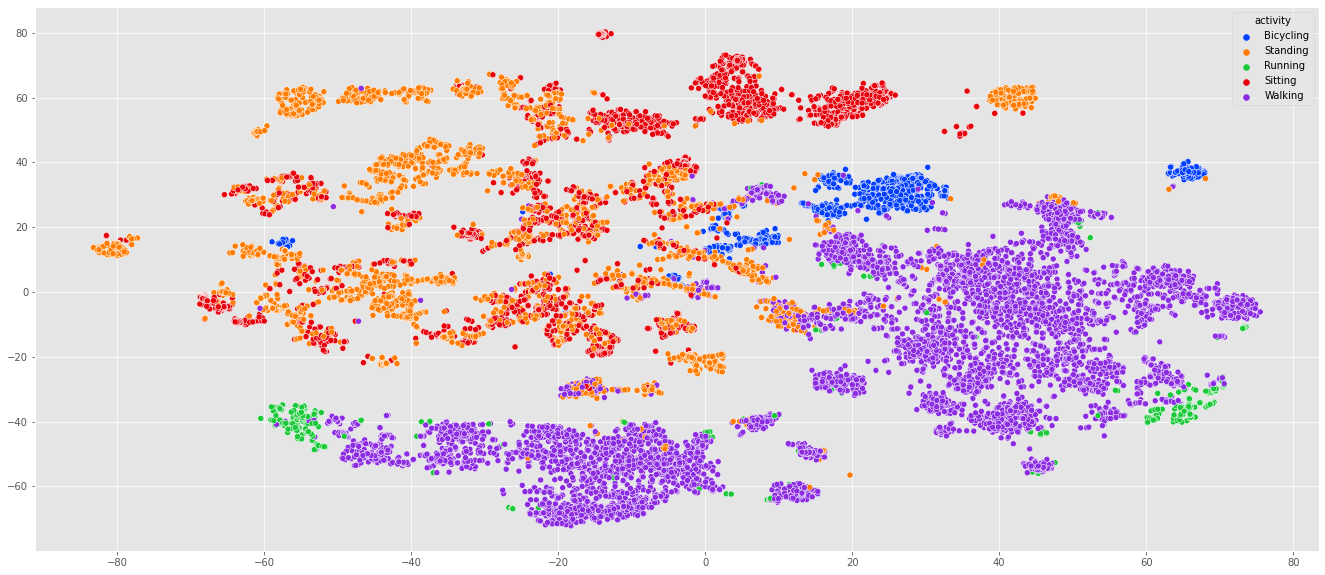

In [ ]:
plt.figure(figsize=(23,10))
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue = df['activity'], palette = "bright");

# Save data in pickle format in google drive


In [ ]:
df.to_pickle("/tmp/df_4.pkl")
X.to_pickle("/tmp/X.pkl")

In [ ]:
!cp /tmp/df_4.pkl /content/drive/MyDrive/myproject/outputdata
!cp /tmp/X.pkl /content/drive/MyDrive/myproject/outputdata